In [1]:
# set to True if in colab
in_colab = False
last_data_idx = -1

In [2]:
import tensorflow as tf
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [17]:
if in_colab:
    import sys
    data_dir = "/content/drive/MyDrive/data/"
    VOC2012_path = data_dir
    tracker_path = data_dir
    sys.path.append(tracker_path)
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    video_path = data_dir + "person_dog.mp4"
    out_path = data_dir + "person_dog_style_transfer.gif"
    style_image_path = data_dir + "style.jpg"
else:
    data_dir = "../data/"
    VOC2012_path = data_dir + "VOCdevkit/"
    tracker_path = "../Tracking_SSD_ReID/"
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    video_path = "../data/video/person_dog.mp4"
    out_path = "../data/video/person_dog_style_transfer.gif"
    style_image_path = "imgs/style_2.jpg"

In [4]:
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import imageio
from tqdm import tqdm
import cv2

## Load style image

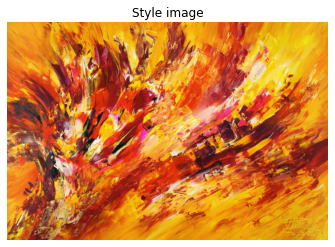

In [18]:
style_image = Image.open(style_image_path)
style_image_np = np.array(style_image)

plt.axis('off')
plt.title("Style image")
plt.imshow(style_image_np)

style_image = cv2.resize(style_image_np, (300, 300),
                           interpolation=cv2.INTER_NEAREST)
style_image = tf.expand_dims(tf.convert_to_tensor(style_image, dtype=tf.float32), 0)

## Load model

In [6]:
from models.VGG16StyleTransfer import VGG16StyleTransfer
model = VGG16StyleTransfer(
    tracker_ssd_path = tracker_path, 
    ssd_weights_path = ssd_weights_path)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=7)

## Infer on single image

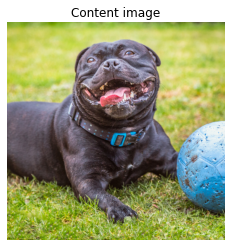

In [7]:
content_image = Image.open("imgs/content.jpg")
content_image_np = np.array(content_image)

plt.axis('off')
plt.title("Content image")
plt.imshow(content_image_np)

content_image = cv2.resize(content_image_np, (300, 300),
                           interpolation=cv2.INTER_NEAREST)
content_image = tf.expand_dims(tf.convert_to_tensor(content_image, dtype=tf.float32), 0)

In [8]:
images = model(style_image, content_image, optimizer, epochs=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


In [8]:
out_gif = "imgs/training.gif"
images[0].save(out_gif, format='GIF',
               append_images=images[1:],
               save_all=True, loop=0)
gif = imageio.mimread(out_gif)
imageio.mimsave(out_gif, gif, fps=2)

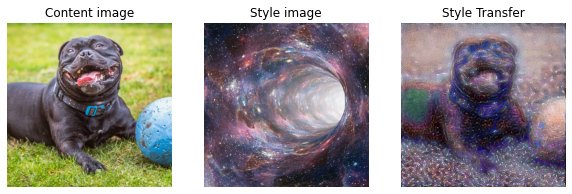

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 15), facecolor='w', edgecolor='k')

axs[0].axis('off')
axs[0].set_title("Content image")
axs[0].imshow(content_image_np)

axs[1].axis('off')
axs[1].set_title("Style image")
axs[1].imshow(style_image_np)

axs[2].axis('off')
axs[2].set_title("Style Transfer")
axs[2].imshow(images[50])

In [14]:
fig.savefig('imgs/style_transfer.png', dpi=75, bbox_inches = 'tight', pad_inches = 0.5)

## Infer on video

In [19]:
model.inferOnVideo(style_image, optimizer, 50, video_path, out_path,
                   start_idx=60, end_idx=62, skip=2, resize=(500,234), fps=22)

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:36<00:00,  1.71it/s]


In [27]:
import imageio
gif_1 = imageio.get_reader("../data/video/person_dog_style_transfer_1.gif", '.gif')
gif_2 = imageio.get_reader("../data/video/person_dog_style_transfer_2.gif", '.gif')
gif_3 = imageio.get_reader("../data/video/person_dog_style_transfer_3.gif", '.gif')
gif_4 = imageio.get_reader("../data/video/person_dog_style_transfer_4.gif", '.gif')

gif_1_imgs = []
for frame in gif_1:
    gif_1_imgs.append(frame)

gif_2_imgs = []
for frame in gif_2:
    gif_2_imgs.append(frame)

gif_3_imgs = []
for frame in gif_3:
    gif_3_imgs.append(frame)

gif_4_imgs = []
for frame in gif_4:
    gif_4_imgs.append(frame)

In [31]:
total_size = (gif_1_imgs[idx].shape[0]*2, gif_1_imgs[idx].shape[1]*2)

print(total_size)
for idx in range(len(gif_1_imgs)):
    print(gif_1_imgs[idx].shape)
    break

(234, 500, 4, 234, 500, 4)
(234, 500, 4)
